## Loading Data
Dan Constantini, Tom Hayat et Alexandre Attia
This script loads 11 data class from imagenet and sort the files according to their name

In [232]:
-- TRAIN SET
require 'torch'
require 'xlua'
require 'image'
require 'nn'
require 'optim'

classes={'bridge', 'building', 'city', 'eiffel_tower','elephant', 'landscape', 'lion', 'monkey', 'people', 'tower', 'water'}

imagesAll = torch.Tensor(1721,3,64,64) 
labelsAll = torch.Tensor(1721)
compteur = 0 -- compteur pour label selon les dir
compteur2 = 0 --compteur pour les images N&B

for dir in paths.iterdirs("./dataset/train/") do
    compteur = compteur +1
    files = {}
    for file in paths.files(paths.concat('./dataset/train/', dir)) do
       if file:find('JPEG' .. '$') then
          table.insert(files, paths.concat(paths.concat('./dataset/train/',dir), file))
       end
    end
   
    if #files == 0 then
       error('given directory doesnt contain any files of type: ')
    end

    -- print(#files)
    temp2 = compteur2
     for i=1,(#files) do
        temp = image.load(files[i])

        if (temp:size()[1]==3) then --on ne prend en compte que les images couleurs
            compteur2 = compteur2 + 1
            imagesAll[temp2 + i] = image.load(files[i]) 
            labelsAll[temp2 + i] = compteur
        end
    end
    collectgarbage()
end


In [233]:
-- TEST SET
imagesTestAll = torch.Tensor(331,3,64,64) 
labelsTestAll = torch.Tensor(331)
compteur3 = 0 -- compteur pour label selon les dir
compteur4 = 0 --compteur pour les images N&B

for dir in paths.iterdirs("./dataset/val/") do
    compteur3 = compteur3 +1
    filesTest = {}
    for file in paths.files(paths.concat('./dataset/val/', dir)) do
       if file:find('JPEG' .. '$') then
          table.insert(filesTest, paths.concat(paths.concat('./dataset/val/',dir), file))
           
       end
    end
   
    if #filesTest == 0 then
       error('given directory doesnt contain any files of type: ')
    end

    -- print(#files)
    temp3 = compteur4
     for i=1,(#filesTest) do
        temp4 = image.load(filesTest[i])

        if (temp4:size()[1]==3) then --on ne prend en compte que les images couleurs
            compteur4 = compteur4 + 1
            imagesTestAll[temp3 + i] = image.load(filesTest[i]) 
            labelsTestAll[temp3 + i] = compteur2
        end
    end
    collectgarbage()
end

In [234]:
-- Nombre d'images couleurs: 1683 
-- Creation du dataset
trainData = {
   data = torch.Tensor(1685, 3, 64, 64),
   labels = torch.Tensor(1685),
}

-- Nombre d'images couleurs : 325
-- Creation test set:
testData = {
      data = torch.Tensor(325, 3, 64, 64),
      labels = torch.Tensor(325),
   }

for i=1,1685 do
   trainData.data[i] = imagesAll[i]
   trainData.labels[i] = labelsAll[i]
end
for i=1,325 do
   testData.data[i] = imagesTestAll[i]
   testData.labels[i] = labelsTestAll[i]
end

In [235]:
print(trainData)
print(testData)

{
  data : FloatTensor - size: 1685x3x64x64
  labels : FloatTensor - size: 1685
}
{
  data : FloatTensor - size: 325x3x64x64
  labels : FloatTensor - size: 325
}


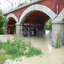

1	


In [242]:
itorch.image(trainData.data[160])
print(trainData.labels[160])


## Preprocessing Data

On convertit nos images RGB en YUV (par rapport à la luminance) puis on normalize (retranche la moyenne et la deviation). Normalisation locale et globale.

In [243]:
-- Convert all images to YUV
print '==> preprocessing data: colorspace RGB -> YUV'
for i = 1,1685 do
   trainData.data[i] = image.rgb2yuv(trainData.data[i])
end
for i = 1,325 do
   testData.data[i] = image.rgb2yuv(testData.data[i])
end


==> preprocessing data: colorspace RGB -> YUV	


In [244]:
-- Name channels for convenience
channels = {'y','u','v'}

-- Normalize each channel, and store mean/std
-- per channel. These values are important, as they are part of
-- the trainable parameters. At test time, test data will be normalized
-- using these values.
print '==> preprocessing data: normalize each feature (channel) globally'
mean = {}
std = {}
for i,channel in ipairs(channels) do
   -- normalize each channel globally:
   mean[i] = trainData.data[{ {},i,{},{} }]:mean()
   std[i] = trainData.data[{ {},i,{},{} }]:std()
   trainData.data[{ {},i,{},{} }]:add(-mean[i])
   trainData.data[{ {},i,{},{} }]:div(std[i])
end

-- Normalize test data, using the training means/stds
for i,channel in ipairs(channels) do
   -- normalize each channel globally:
   testData.data[{ {},i,{},{} }]:add(-mean[i])
   testData.data[{ {},i,{},{} }]:div(std[i])
end

==> preprocessing data: normalize each feature (channel) globally	


In [245]:
-- Local normalization
print '==> preprocessing data: normalize all three channels locally'

-- Define the normalization neighborhood:
neighborhood = image.gaussian1D(13)

-- Define our local normalization operator (It is an actual nn module, 
-- which could be inserted into a trainable model):
normalization = nn.SpatialContrastiveNormalization(1, neighborhood)

-- Normalize all channels locally:
for c in ipairs(channels) do
   for i = 1,1685 do
      trainData.data[{ i,{c},{},{} }] = normalization:forward(trainData.data[{ i,{c},{},{} }])
   end
   for i = 1,325 do
      testData.data[{ i,{c},{},{} }] = normalization:forward(testData.data[{ i,{c},{},{} }])
   end
end


==> preprocessing data: normalize all three channels locally	


Verification de la normalisation :

In [246]:
print '==> verify statistics'
for i,channel in ipairs(channels) do
   trainMean = trainData.data[{ {},i }]:mean()
   trainStd = trainData.data[{ {},i }]:std()

   testMean = testData.data[{ {},i }]:mean()
   testStd = testData.data[{ {},i }]:std()

   print('training data, '..channel..'-channel, mean: ' .. trainMean)
   print('training data, '..channel..'-channel, standard deviation: ' .. trainStd)

   print('test data, '..channel..'-channel, mean: ' .. testMean)
   print('test data, '..channel..'-channel, standard deviation: ' .. testStd)
end


==> verify statistics	


training data, y-channel, mean: -0.013991548668763	
training data, y-channel, standard deviation: 0.86405389462295	
test data, y-channel, mean: -0.017127864737501	
test data, y-channel, standard deviation: 0.86482605024975	


training data, u-channel, mean: 0.017287004507574	
training data, u-channel, standard deviation: 0.86037302478448	
test data, u-channel, mean: 0.019265276341839	
test data, u-channel, standard deviation: 0.86349893867672	


training data, v-channel, mean: -0.015198449729941	
training data, v-channel, standard deviation: 0.85595067449338	
test data, v-channel, mean: -0.017565861141334	
test data, v-channel, standard deviation: 0.8590854625242	


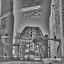

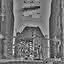

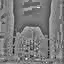

In [247]:
first256Samples_y = trainData.data[{ 1,1 }]
   first256Samples_u = trainData.data[{ 1,2 }]
   first256Samples_v = trainData.data[{ 1,3 }]
   itorch.image(first256Samples_y)
   itorch.image(first256Samples_u)
   itorch.image(first256Samples_v)

--> Normalisation différente de celle du fichier test. Pourquoi ? Quelle différence ?

## Model

In [248]:
-- define model to train
model = nn.Sequential()

--[[ stage 1 : mean+std normalization -> filter bank -> squashing -> max pooling
-- Convolution
model:add(nn.SpatialConvolutionMM(3,32,5,5))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))

-- stage 2 : filter bank -> squashing -> max pooling
model:add(nn.SpatialConvolutionMM(32,32,5,5))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))
]]

-- stage 3 : standard 2-layer neural network
-- Neural Network Linéaire
model:add(nn.View(3*64*64))
model:add(nn.Linear(3*64*64, #classes))
--model:add(nn.ReLU())
--model:add(nn.Linear(128,#classes))
model:add(nn.LogSoftMax())


In [249]:
print '==> vizualisation du modèle'
print(model:__tostring())

==> vizualisation du modèle	
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> output]
  (1): nn.View(12288)
  (2): nn.Linear(12288 -> 11)
  (3): nn.LogSoftMax
}	


In [250]:
-- retrieve parameters and gradients. this helps us to use the optim package
parameters,gradParameters = model:getParameters()

In [251]:
-- loss function: negative log-likelihood
criterion = nn.ClassNLLCriterion()
print (criterion)

nn.ClassNLLCriterion
{
  sizeAverage : true
  output : 0
  gradInput : FloatTensor - empty
  output_tensor : FloatTensor - size: 1
  target : LongTensor - size: 1
  total_weight_tensor : FloatTensor - size: 1
}


In [252]:
batchSize = 64 -- sets the mini-Batch size

In [253]:
-- this matrix records the current confusion across classes
confusion = optim.ConfusionMatrix(classes)

--Verfication qu'ils aient tous des labels
temp=0
for i=1,1685 do 
    if trainData.labels[i] == 0 then
        temp= temp+1
        print(i)
    end
end
print (temp)

0	


## Training 

In [254]:
i=0
while i<10 do
    train(trainData)
    i=i+1
end

<trainer> on training set:	
<trainer> online epoch # 1 [batchSize = 64]	


...s/alexandreattia/torch/install/share/lua/5.1/nn/THNN.lua:109: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/alexandreattia/torch/extra/nn/lib/THNN/generic/ClassNLLCriterion.c:38
stack traceback:
	[C]: in function 'v'
	...s/alexandreattia/torch/install/share/lua/5.1/nn/THNN.lua:109: in function 'ClassNLLCriterion_updateOutput'
	...tia/torch/install/share/lua/5.1/nn/ClassNLLCriterion.lua:41: in function 'forward'
	[string "-- training function..."]:38: in function 'opfunc'
	...alexandreattia/torch/install/share/lua/5.1/optim/sgd.lua:44: in function 'sgd'
	[string "-- training function..."]:62: in function 'train'
	[string "i=0..."]:3: in main chunk
	[C]: in function 'xpcall'
	...exandreattia/torch/install/share/lua/5.1/itorch/main.lua:209: in function <...exandreattia/torch/install/share/lua/5.1/itorch/main.lua:173>
	...exandreattia/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...ndreattia/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...ndreattia/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...ndreattia/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...exandreattia/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x01098f1bb0: 

## Testing

In [85]:
-- test function
function test(dataset)

   -- test over given dataset
   print('<trainer> on testing Set:')
   for t = 1,325 do
      -- get new sample
      local input = dataset.data[t]
      local target = dataset.labels[t]

      -- test sample
      local pred = model:forward(input)
      confusion:add(pred, target)
   end

   -- print confusion matrix
   print(confusion)
   confusion:zero()

end